# **Per Day**

## *Initialize*

##### Note about outliers and normalization
##### Given that we must avoid any  bias it is not possible to use future information to filter past outliers. Outliers, normalization and filtering analysis in time series requires to be more cautious than with regular data.One way to deal with outliers and normalization is by doing it in a rolling basis. For outliers we can compute the mean and standard deviation of our data and check which values are at a given N standard deviations above or below the mean, those values will be regarded as outliers.
##### Given that the model we are building here will just rely on past measurements of the same feature there is no need to normalize our data, provided that all the features are of the same scale and we are not using any deep learning approaches.


## **Exploring and Preprocessing**

## For more info go to functions.py documentation.

In [1]:
from functions import *
#in order to get only the rows at 8 am.
#!awk '/08:00:00/{print $0}' station_hour.csv > station_hour_8am.csv (need to add the header: StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket)
#The time is choosen arbitarily just to have data each 24 hours.

In [2]:
data = pd.read_csv('station_hour_8am.csv')
print(data.columns)
print('#######')
print(data.shape)
print('#######')
data.head()

Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')
#######
(107839, 16)
#######


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-25 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AP001,2017-11-26 08:00:00,97.75,143.00,2.00,38.48,22.12,10.73,0.1,16.12,92.12,0.30,11.03,0.15,191.0,Moderate
2,AP001,2017-11-27 08:00:00,98.00,142.00,7.05,35.60,24.67,14.47,0.1,6.00,21.55,0.33,8.60,0.15,173.0,Moderate
3,AP001,2017-11-28 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AP001,2017-11-29 08:00:00,95.00,142.75,3.40,33.67,20.68,14.95,0.2,14.47,88.20,0.30,6.40,0.13,160.0,Moderate


In [3]:
#The AQI calculation uses 7 measures: PM2.5, PM10, SO2, NOx, NH3, CO and O3
print('''For PM2.5, PM10, SO2, NOx and NH3 the average value in last 24-hrs is used with the condition of having at least 16 values.

For CO and O3 the maximum value in last 8-hrs is used.''')

data = data[['StationId','Datetime','PM2.5','PM10','SO2','NOx','NH3','CO','O3','AQI','AQI_Bucket']]
data.head(3)

For PM2.5, PM10, SO2, NOx and NH3 the average value in last 24-hrs is used with the condition of having at least 16 values.

For CO and O3 the maximum value in last 8-hrs is used.


,StationId,Datetime,PM2.5,PM10,SO2,NOx,NH3,CO,O3,AQI,AQI_Bucket
0,AP001,2017-11-25 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AP001,2017-11-26 08:00:00,97.75,143.0,16.12,22.12,10.73,0.1,92.12,191.0,Moderate
2,AP001,2017-11-27 08:00:00,98.00,142.0,6.00,24.67,14.47,0.1,21.55,173.0,Moderate


In [4]:
# searching for missing data on target
data[np.isnan(data['AQI'])].head(3)
len(data[np.isnan(data['AQI'])])

23428

In [5]:
#extracting all stations names 
stations=list(data["StationId"].unique())
#checking
stations[:2]

['AP001', 'AP005']

#### For one test station (AP001)

In [6]:
train_data,test_data =get_station_training_test_data(station_name=stations[0],full_data=data)
print(train_data.head(2))
print('####')
print(test_data.head(2))

  StationId             Datetime  PM2.5   PM10    SO2    NOx    NH3   CO  \
0     AP001  2017-11-25 08:00:00    NaN    NaN    NaN    NaN    NaN  NaN   
1     AP001  2017-11-26 08:00:00  97.75  143.0  16.12  22.12  10.73  0.1   

      O3    AQI AQI_Bucket  
0    NaN    NaN        NaN  
1  92.12  191.0   Moderate  
####
    StationId             Datetime  PM2.5    PM10    SO2    NOx    NH3    CO  \
712     AP001  2019-11-07 08:00:00  87.75  143.75   9.78  17.73  12.20  0.96   
713     AP001  2019-11-08 08:00:00  87.00  114.00  13.95  15.90  12.38  0.77   

       O3    AQI AQI_Bucket  
712  18.5  201.0       Poor  
713  23.9  175.0   Moderate  


### Dealing with missing values

In [7]:
print(train_data['AQI'].isnull().sum())
print(train_data['AQI_Bucket'].isnull().sum())

126
126


In [8]:
#replace nans with median
train_data['AQI'] = train_data['AQI'].fillna(train_data['AQI'].median())
train_data['AQI_Bucket'] = train_data['AQI_Bucket'].fillna('Satisfactory')
print('median AQI',train_data['AQI'].median())
train_data.head(3)

median AQI 80.0


,StationId,Datetime,PM2.5,PM10,SO2,NOx,NH3,CO,O3,AQI,AQI_Bucket
0,AP001,2017-11-25 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,Satisfactory
1,AP001,2017-11-26 08:00:00,97.75,143.0,16.12,22.12,10.73,0.1,92.12,191.0,Moderate
2,AP001,2017-11-27 08:00:00,98.00,142.0,6.00,24.67,14.47,0.1,21.55,173.0,Moderate


In [9]:
#replace nans with median
test_data['AQI'] = test_data['AQI'].fillna(test_data['AQI'].median())
test_data['AQI_Bucket'] = test_data['AQI_Bucket'].fillna('Satisfactory')
test_data.head(3)

,StationId,Datetime,PM2.5,PM10,SO2,NOx,NH3,CO,O3,AQI,AQI_Bucket
712,AP001,2019-11-07 08:00:00,87.75,143.75,9.78,17.73,12.20,0.96,18.50,201.0,Poor
713,AP001,2019-11-08 08:00:00,87.00,114.00,13.95,15.90,12.38,0.77,23.90,175.0,Moderate
714,AP001,2019-11-09 08:00:00,80.25,118.25,13.70,6.93,14.17,0.73,39.88,172.0,Moderate


In [10]:
print(test_data['AQI'].isnull().sum())
print(test_data['AQI_Bucket'].isnull().sum())
print(train_data['AQI'].isnull().sum())
print(train_data['AQI_Bucket'].isnull().sum())


0
0
0
0


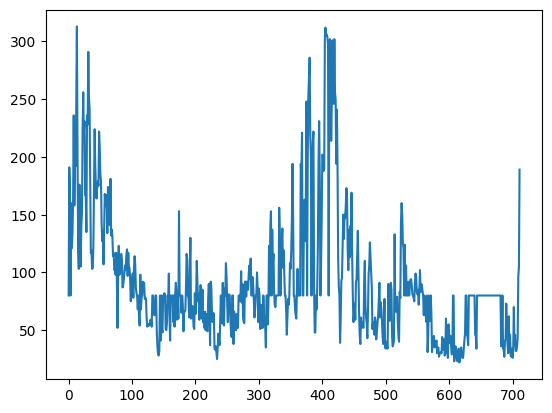

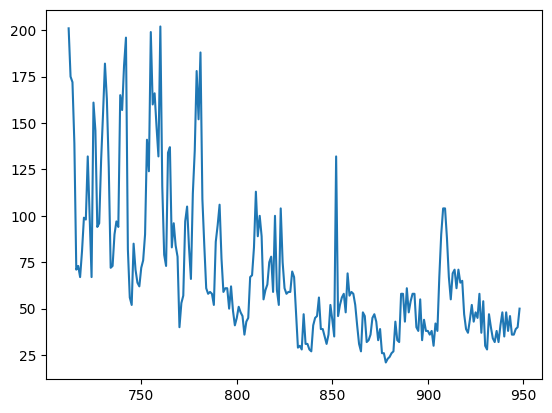

In [11]:
plt.plot(train_data['AQI'])
plt.show()
plt.plot(test_data['AQI'])
plt.show()

### Outliers

In [12]:
#number of past observations for preprocessing training data
num_past_observation_prepro=40

In [13]:
#Removing Outliers, num_past_observation_prepro days window. Deviation=2 standar deviations
# 0== no outlier; 1==outlier
outliers_df=outliers_filter(train_data['AQI'],window=num_past_observation_prepro,threshold=3)
print(outliers_df.head(2))
print("######")
#actual outliers
outliers=outliers_df[outliers_df['outlier_signal']==1]
print(outliers.head(2))
#Create list with the outliers indexes to be removed
list_outliers_indexes = outliers.index.to_list()
len(list_outliers_indexes)

   Value  outlier_signal
0   80.0               0
1  191.0               0
######
     Value  outlier_signal
174  153.0               1
319  153.0               1


11

In [14]:
list_outliers_indexes

[174, 319, 524, 525, 566, 682, 683, 685, 686, 687, 711]

In [15]:
train_data.drop(index=list_outliers_indexes)

,StationId,Datetime,PM2.5,PM10,SO2,NOx,NH3,CO,O3,AQI,AQI_Bucket
0,AP001,2017-11-25 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,Satisfactory
1,AP001,2017-11-26 08:00:00,97.75,143.00,16.12,22.12,10.73,0.10,92.12,191.0,Moderate
2,AP001,2017-11-27 08:00:00,98.00,142.00,6.00,24.67,14.47,0.10,21.55,173.0,Moderate
3,AP001,2017-11-28 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,Satisfactory
4,AP001,2017-11-29 08:00:00,95.00,142.75,14.47,20.68,14.95,0.20,88.20,160.0,Moderate
...,...,...,...,...,...,...,...,...,...,...,...
706,AP001,2019-11-01 08:00:00,13.00,31.75,13.95,13.43,6.35,0.59,17.27,32.0,Good
707,AP001,2019-11-02 08:00:00,11.75,42.50,12.18,19.12,6.30,0.55,10.47,36.0,Good
708,AP001,2019-11-03 08:00:00,20.00,48.50,13.30,13.15,7.75,0.59,16.95,43.0,Good
709,AP001,2019-11-04 08:00:00,55.00,108.00,14.00,15.07,9.82,0.68,13.90,96.0,Satisfactory


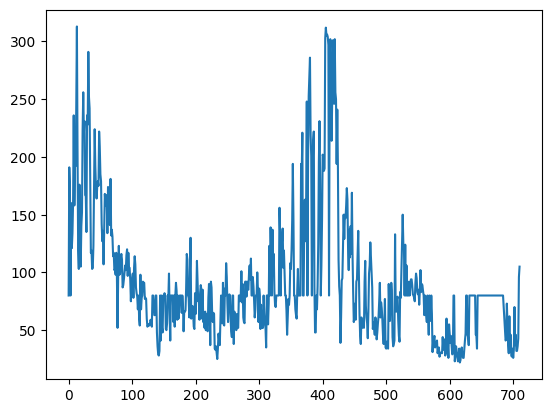

In [16]:
#Train data with outliers removed
train_data_no_outliers = train_data.drop(index=list_outliers_indexes)
plt.plot(train_data_no_outliers['AQI'])

### **Checking the composition of the series**

### From below we can notice that there is no clear upward or downward trend hence we dont need to detrend the data
### also if we play with different periods we can see there is seasonality in our data.

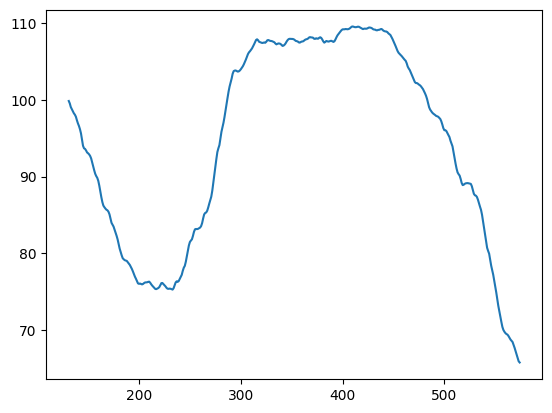

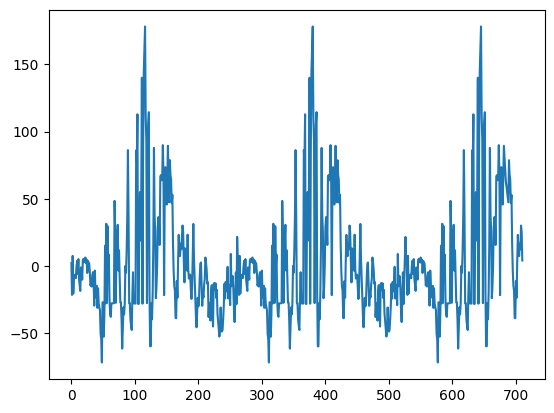

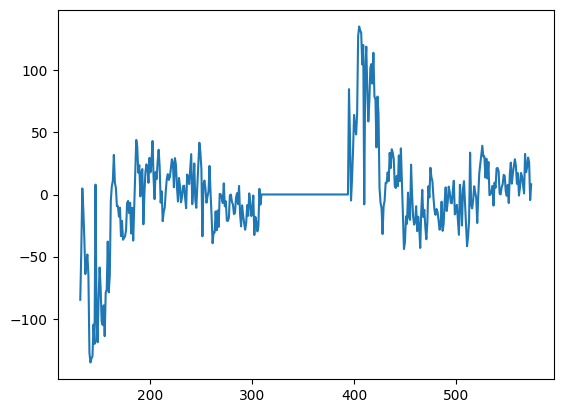

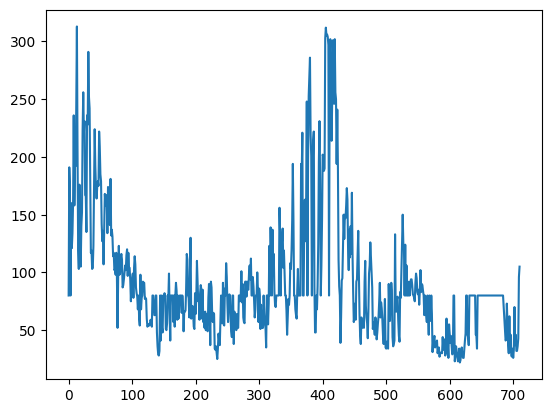

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = train_data_no_outliers[['AQI']]
result = seasonal_decompose(series, model='additive',period=262)
plt.plot(result.trend)
plt.show()
plt.plot(result.seasonal)
plt.show()
plt.plot(result.resid)
plt.show()
plt.plot(result.observed)
plt.show()

### Checking Detrending
##### no obvious trend in our data, hence 
##### we do not apply detrending

## **Denoising: Moving average**
##### Given our problem is a timeseries if we 
##### denoise our data, train and test data must be separated
##### to avoid future-obersevations related bias

In [18]:
#we take a rolling average N=3 to denoise the signal
N=3
len(np.convolve(train_data_no_outliers['AQI'], np.ones(N)/N, mode='valid'))

699

In [19]:
# we denoise by separate the test and train data sets
train_data_no_outliers_convolved=pd.Series(np.convolve(train_data_no_outliers['AQI'], np.ones(N)/N, mode='valid'))
test_data_convolved=pd.Series(np.convolve(test_data['AQI'], np.ones(N)/N, mode='valid'))

In [20]:
#data to build our model
data_to_model = train_data_no_outliers_convolved #data_to_model = detrend(train_data_no_outliers['AQI'])
df_data_to_model = pd.DataFrame(data_to_model)
df_data_to_model.rename(columns={0: "AQI"},inplace=True)

#data to test our model
AQI_test_data = test_data_convolved #data_to_model = detrend(train_data_no_outliers['AQI'])
AQI_test_data = pd.DataFrame(AQI_test_data)
AQI_test_data.rename(columns={0: "AQI"},inplace=True)


# we create a lagged data to use past data to predict future data, if we use a window equal to 30, leans 30 previous measurements were taken to predict AQI the next day.
#TRAIN DATA
num_past_observations_model=70
predictors,targets=create_lagged_data(window=num_past_observations_model,dataframe=df_data_to_model,feature="AQI")

#TEST DATA
#here we have the previous meausurement that we will input in our trained model
#whilst targets_test represents the ground truth to verify how good our model is
predictors_test,targets_test_smoothed = create_lagged_data(window=num_past_observations_model,dataframe=AQI_test_data,feature="AQI") 

#IMPORTANT!!!
#we must used the actual test_data (not the smoothed one) to check the precission of our model
# the variable "targets_test_smoothed" is not used, it's left for completeness.
targets_test=test_data[N+(num_past_observations_model-1):]['AQI']



### Linear Regression

train r2 squared error is  71.96104803025099
test r2 squared error is  248.91939796524133


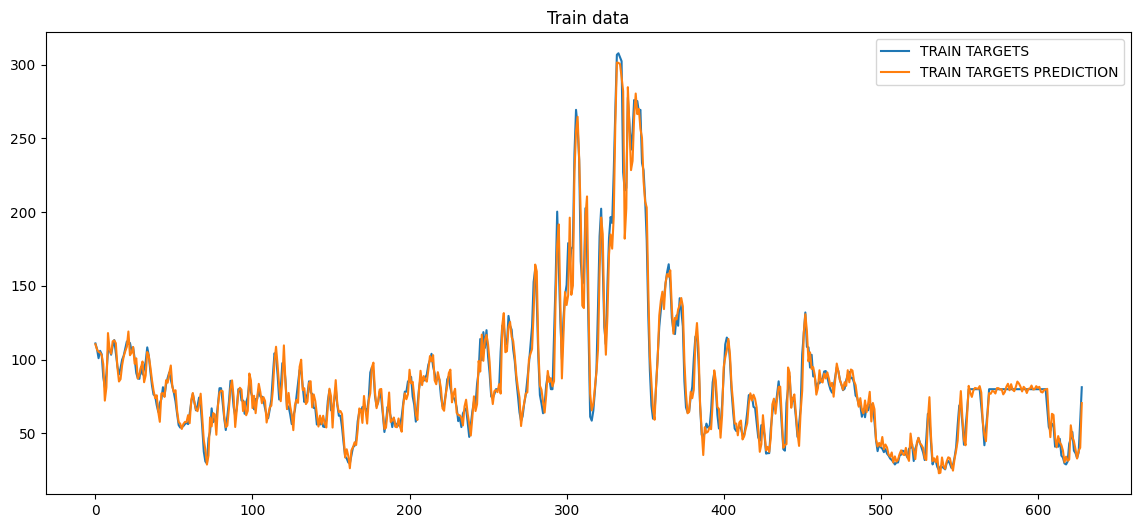

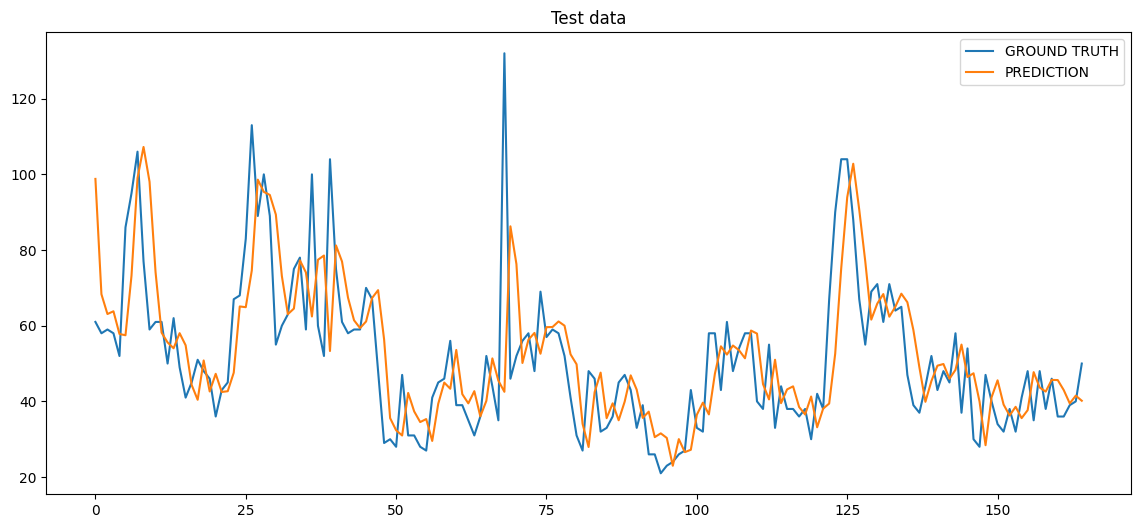

In [21]:

## Linear regression model
model = LinearRegression()
model.fit(X=predictors, y=targets)
# save the model to disk
filename = 'model_LR_v-1.pkl'
pickle.dump(model, open(filename, 'wb'))

# using model on the same training data for completeness
train_pred = model.predict(predictors)
# Plot prediction with test data
test_pred = model.predict(predictors_test)
# Plot prediction with train data
plt.figure(figsize=(14,6))
plt.title('Train data')
plt.plot(range(len(targets)), targets, label='TRAIN TARGETS')
plt.plot(range(len(train_pred)), train_pred, label='TRAIN TARGETS PREDICTION')
plt.legend()
# Plot prediction with test data
test_pred = model.predict(predictors_test)
plt.figure(figsize=(14,6))
plt.title('Test data')
plt.plot(range(len(targets_test)), targets_test, label='GROUND TRUTH')
plt.plot(range(len(test_pred)), test_pred, label='PREDICTION')
plt.legend()

# R squared score for test data
print("train r2 squared error is ", rsquared(targets, train_pred)) #rsquared(targets, train_pred))
print("test r2 squared error is ", rsquared(targets_test, test_pred))#rsquared(targets_test, test_pred))

### Random Forest regressor

train r2 squared error is  24.477700670155475
test r2 squared error is  275.0227809385522


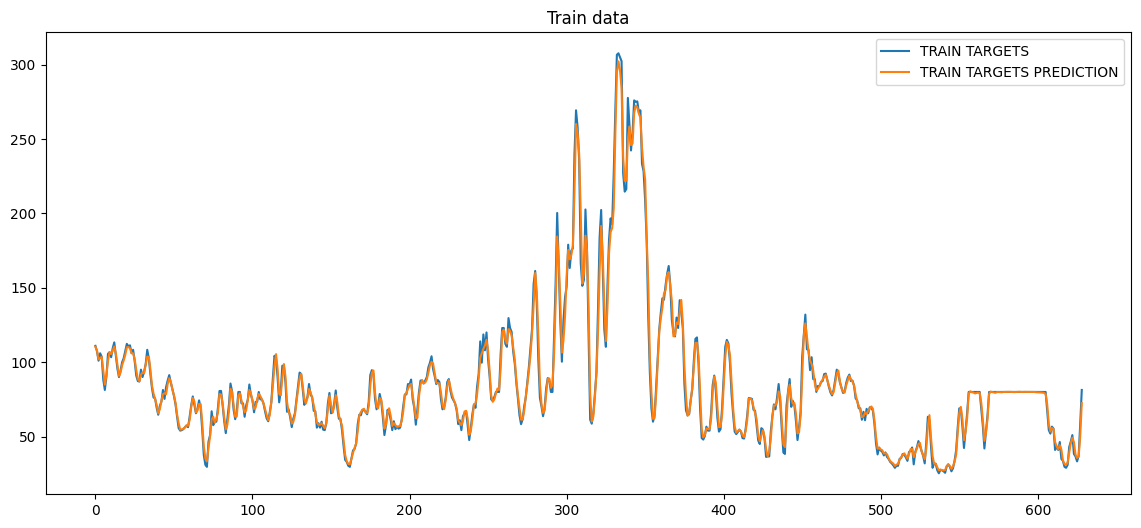

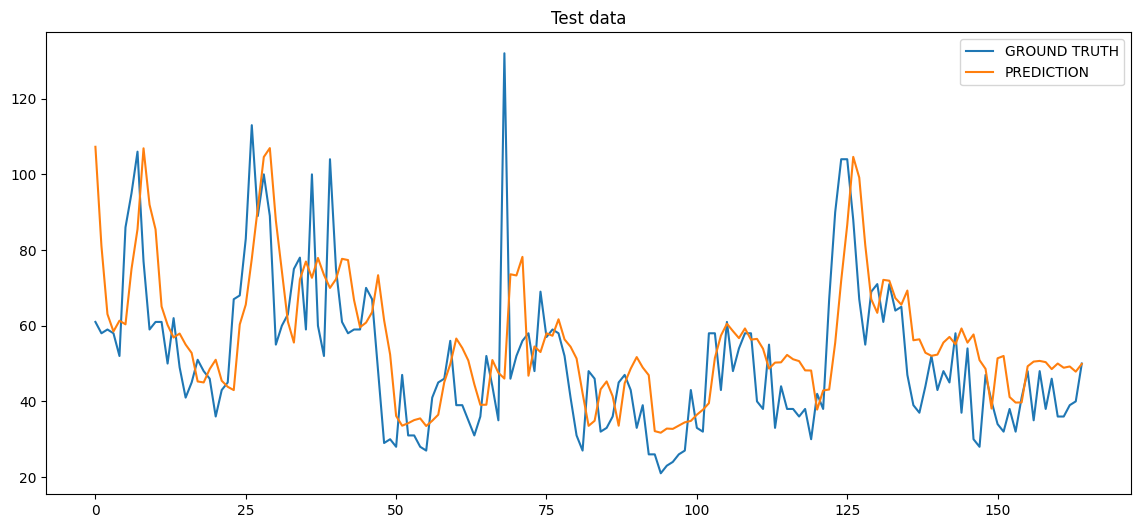

In [22]:
from functions import *
n_estimators_rf=400
model = RandomForestRegressor(n_estimators=n_estimators_rf)
model.fit(X=predictors, y=targets)
# save the model to disk
filename = 'model_LR_v-1.pkl'
pickle.dump(model, open(filename, 'wb'))

# using model on the same training data
train_pred = model.predict(predictors)
# Plot prediction with test data
test_pred = model.predict(predictors_test)
# R squared score for test data



# Plot prediction with train data
plt.figure(figsize=(14,6))
plt.title('Train data')
plt.plot(range(len(targets)), targets, label='TRAIN TARGETS')
plt.plot(range(len(train_pred)), train_pred, label='TRAIN TARGETS PREDICTION')
plt.legend()

# Plot prediction with test data
test_pred = model.predict(predictors_test)
plt.figure(figsize=(14,6))
plt.title('Test data')
plt.plot(range(len(targets_test)), targets_test, label='GROUND TRUTH')
plt.plot(range(len(test_pred)), test_pred, label='PREDICTION')

plt.legend()

# R squared score for test data
print("train r2 squared error is ", rsquared(targets, train_pred))
print("test r2 squared error is ", rsquared(targets_test, test_pred))

### xgboost model

train r2 squared error is  3.6053590986215083
test r2 squared error is  293.6355568087339


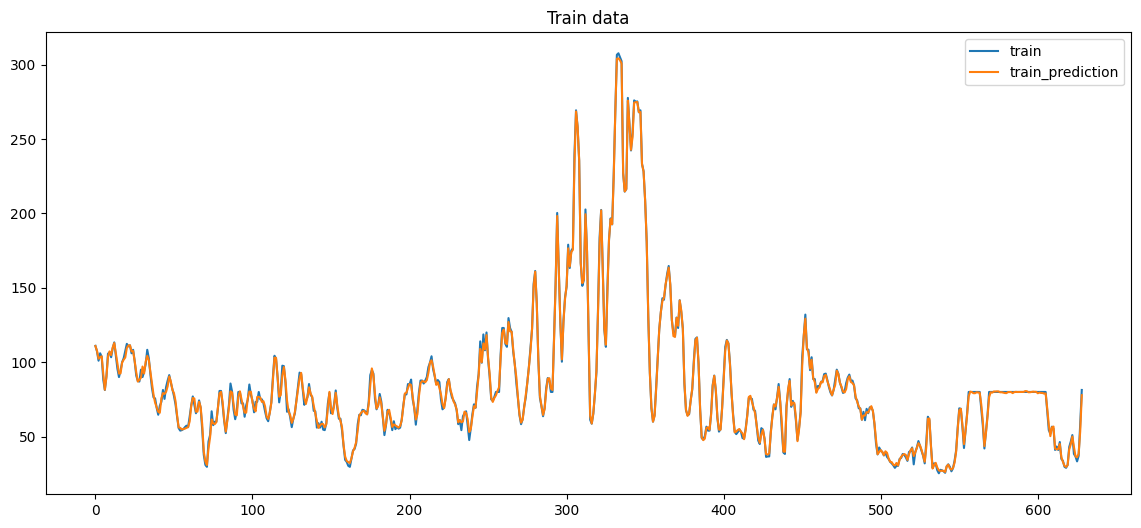

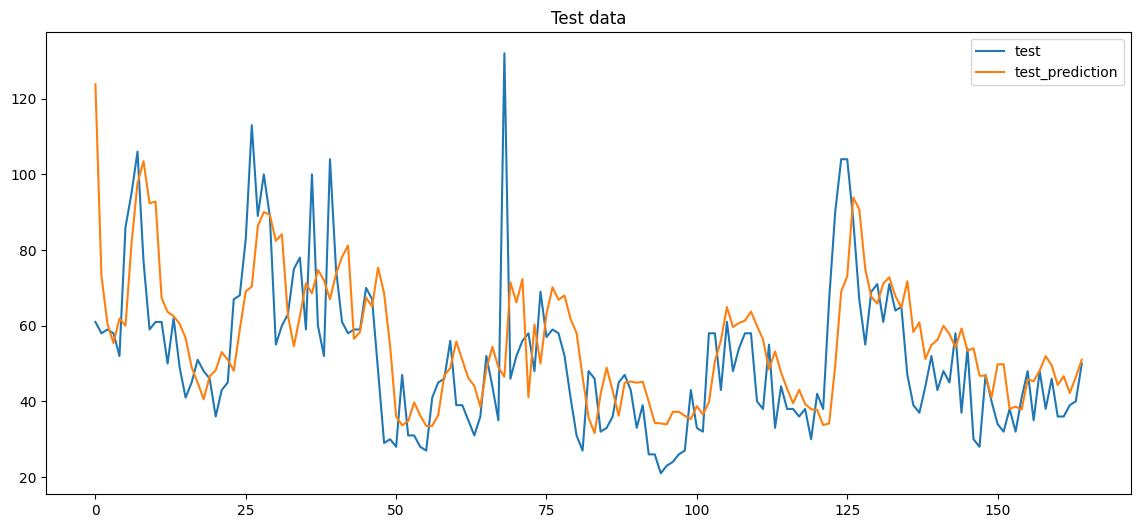

In [23]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(predictors, targets, enable_categorical=False)
dtest_reg = xgb.DMatrix(predictors_test, targets_test, enable_categorical=False)
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 20

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

train_pred = model.predict((dtrain_reg))
test_pred = model.predict(dtest_reg)

# Plot prediction with train data
plt.figure(figsize=(14,6))
plt.title('Train data')
plt.plot(range(len(targets)), targets, label='train')
plt.plot(range(len(train_pred)), train_pred, label='train_prediction')
plt.legend()
print("train r2 squared error is ", rsquared(targets, train_pred))

# Plot prediction with test data
plt.figure(figsize=(14,6))
plt.title('Test data')
plt.plot(range(len(targets_test)), targets_test, label='test')
plt.plot(range(len(test_pred)), test_pred, label='test_prediction')

plt.legend()

# R squared score for test data
print("test r2 squared error is ", rsquared(targets_test, test_pred))

# ***Per Month***

In [24]:
from functions import *
stations =['AP001', 'AP005', 'AS001', 'BR005', 'BR006', 'BR007', 'BR008',
       'BR009', 'BR010', 'CH001', 'DL001', 'DL002', 'DL003', 'DL004',
       'DL005', 'DL006', 'DL007', 'DL008', 'DL009', 'DL010', 'DL011',
       'DL012', 'DL013', 'DL014', 'DL015', 'DL016', 'DL017', 'DL018',
       'DL019', 'DL020', 'DL021', 'DL022', 'DL023', 'DL024', 'DL025',
       'DL026', 'DL027', 'DL028', 'DL029', 'DL030', 'DL031', 'DL032',
       'DL033', 'DL034', 'DL035', 'DL036', 'DL037', 'DL038', 'GJ001',
       'HR011', 'HR012', 'HR013', 'HR014', 'JH001', 'KA002', 'KA003',
       'KA004', 'KA005', 'KA006', 'KA007', 'KA008', 'KA009', 'KA010',
       'KA011', 'KL002', 'KL004', 'KL007', 'KL008', 'MH005', 'MH006',
       'MH007', 'MH008', 'MH009', 'MH010', 'MH011', 'MH012', 'MH013',
       'MH014', 'ML001', 'MP001', 'MZ001', 'OD001', 'OD002', 'PB001',
       'RJ004', 'RJ005', 'RJ006', 'TG001', 'TG002', 'TG003', 'TG004',
       'TG005', 'TG006', 'TN001', 'TN002', 'TN003', 'TN004', 'TN005',
       'UP012', 'UP013', 'UP014', 'UP015', 'UP016', 'WB007', 'WB008',
       'WB009', 'WB010', 'WB011', 'WB012', 'WB013']

In [25]:
#We use awk to get only the data corresponding to a 15th day
#awk '/-15/{print $0}' station_hour.csv > station_hour_15th.csv

In [26]:
#We want to work with the median AQI of each month's 15th day 
#This is arbitrary we could pick other day not just the 15th

In [27]:
#any_station_month(general_file='station_hour_15th.csv',ml_algor='lr',name=stations[0],num_past_observations_model=5)

In [28]:
#checking for one station
data = pd.read_csv('station_hour_15th.csv')
data = data[data['StationId']==stations[0]]

In [29]:
# To facilitate the pattern grabbing we create a column with only the date, no time.
dates = pd.DatetimeIndex(data=data['Datetime'])
only_date = dates.date   
data['Date']=only_date
data.head(2)

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,Date
0,AP001,2017-12-15 00:00:00,68.0,91.00,1.12,12.17,7.37,17.70,0.10,7.9,73.00,0.10,4.10,0.0,134.0,Moderate,2017-12-15
1,AP001,2017-12-15 01:00:00,70.5,94.25,0.85,16.33,9.35,18.15,0.08,6.0,56.85,0.15,4.22,0.0,136.0,Moderate,2017-12-15


In [30]:
# we extract the unique dates values from the dataframe
only_date_unique =list(only_date)
only_date_unique = list(dict.fromkeys(only_date_unique))
print(only_date_unique) 

[datetime.date(2017, 12, 15), datetime.date(2018, 1, 15), datetime.date(2018, 2, 15), datetime.date(2018, 3, 15), datetime.date(2018, 4, 15), datetime.date(2018, 5, 15), datetime.date(2018, 6, 15), datetime.date(2018, 7, 15), datetime.date(2018, 8, 15), datetime.date(2018, 9, 15), datetime.date(2018, 10, 15), datetime.date(2018, 11, 15), datetime.date(2018, 12, 15), datetime.date(2019, 1, 15), datetime.date(2019, 2, 15), datetime.date(2019, 3, 15), datetime.date(2019, 4, 15), datetime.date(2019, 5, 15), datetime.date(2019, 6, 15), datetime.date(2019, 7, 15), datetime.date(2019, 8, 15), datetime.date(2019, 9, 15), datetime.date(2019, 10, 15), datetime.date(2019, 11, 15), datetime.date(2019, 12, 15), datetime.date(2020, 1, 15), datetime.date(2020, 2, 15), datetime.date(2020, 3, 15), datetime.date(2020, 4, 15), datetime.date(2020, 5, 15), datetime.date(2020, 6, 15)]


In [31]:
#we calculate the median value of each 15th day 
#for each unique date, leaving only one value per one date
medians_15_th=[]
for i in range(len(only_date_unique)):
    df = data.where(data["Date"]==only_date_unique[i])
    medians_15_th.append(df['AQI'].median())

/home/daniel/miniconda3/envs/gpu/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/daniel/miniconda3/envs/gpu/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [32]:
#Now we leave only one value per date of the dataframe, we choose '00:00:00', 
#this is arbitrary
#could be any since the value we will focus from now on is the median value
mask=data.Datetime.str.contains('00:00:00')
data_with_one_entry_per_day = data[mask]
data_with_one_entry_per_day['AQI_median']=medians_15_th
data_with_one_entry_per_day.head(2)

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,Date,AQI_median
0,AP001,2017-12-15 00:00:00,68.0,91.0,1.12,12.17,7.37,17.70,0.10,7.90,73.00,0.1,4.10,0.0,134.0,Moderate,2017-12-15,140.0
24,AP001,2018-01-15 00:00:00,75.0,122.0,0.78,20.00,11.23,21.07,0.05,4.23,35.78,0.2,7.43,0.1,188.0,Moderate,2018-01-15,174.0


In [33]:
#we extract only the data we will use
data_clean = data_with_one_entry_per_day[["Datetime","StationId","AQI_median"]]
data_clean.head()

,Datetime,StationId,AQI_median
0,2017-12-15 00:00:00,AP001,140.0
24,2018-01-15 00:00:00,AP001,174.0
48,2018-02-15 00:00:00,AP001,111.0
72,2018-03-15 00:00:00,AP001,60.0
96,2018-04-15 00:00:00,AP001,29.5


In [34]:
train_data=data_clean[:round(0.75*len(data_clean))]    
test_data=data_clean[round(0.75*len(data_clean)):]    


In [35]:
len(train_data)

23

## Dealing with missing values

In [36]:
print(train_data['AQI_median'].isnull().sum())
#print(train_data['AQI_Bucket_median'].isnull().sum())

2


In [37]:
#replace nans with median
train_data['AQI_median'] = train_data['AQI_median'].fillna(train_data['AQI_median'].median())
#train_data['AQI_Bucket'] = train_data['AQI_Bucket'].fillna('Satisfactory')
#print('median AQI',train_data['AQI'].median())
train_data.head(3)

,Datetime,StationId,AQI_median
0,2017-12-15 00:00:00,AP001,140.0
24,2018-01-15 00:00:00,AP001,174.0
48,2018-02-15 00:00:00,AP001,111.0


In [38]:
#replace nans with median
test_data['AQI_median'] = test_data['AQI_median'].fillna(test_data['AQI_median'].median())
#test_data['AQI_Bucket'] = test_data['AQI_Bucket'].fillna('Satisfactory')
#test_data.head(3)

In [39]:
print(test_data['AQI_median'].isnull().sum())
#print(test_data['AQI_Bucket'].isnull().sum())
print(train_data['AQI_median'].isnull().sum())
#print(train_data['AQI_Bucket'].isnull().sum())


0
0


In [40]:
#restored_data = train_data.append(test_data)
#restored_data.to_csv('station_hour_restored.csv')
len(test_data)

8

In [41]:
# we recalculate the AQI_bucket value for the AQI_median
aqi_bucket_median_train=[]
for i in train_data["AQI_median"]:
        if round(i)<=50:
            aqi_bucket_median_train.append("Good")
        elif 51 <= round(i) <=100:
            aqi_bucket_median_train.append('Satisfactory')
        elif 101<=round(i)<=200:
            aqi_bucket_median_train.append("Moderate")
        elif 201<=round(i)<=300:
            aqi_bucket_median_train.append('Poor')
        elif 301<=round(i)<=400:
            aqi_bucket_median_train.append('Very poor')
        elif round(i)>=401:
            aqi_bucket_median_train.append('Severe')
        else:
            aqi_bucket_median_train.append('ERROR',i)
# we recalculate the AQI_bucket value for the AQI_median
aqi_bucket_median_test=[]
for i in test_data["AQI_median"]:
        if round(i)<=50:
            aqi_bucket_median_test.append("Good")
        elif 51 <= round(i) <=100:
            aqi_bucket_median_test.append('Satisfactory')
        elif 101<=round(i)<=200:
            aqi_bucket_median_test.append("Moderate")
        elif 201<=round(i)<=300:
            aqi_bucket_median_test.append('Poor')
        elif 301<=round(i)<=400:
            aqi_bucket_median_test.append('Very poor')
        elif round(i)>=401:
            aqi_bucket_median_test.append('Severe')
        else:
            aqi_bucket_median_test.append('ERROR',i)

In [42]:
train_data["AQI_Bucket_median"]=aqi_bucket_median_train
test_data["AQI_Bucket_median"]=aqi_bucket_median_test

In [43]:
#data to build our model
data_to_model = train_data["AQI_median"] #data_to_model = detrend(train_data_no_outliers['AQI'])
df_data_to_model = pd.DataFrame(data_to_model)
df_data_to_model.rename(columns={0: "AQI"},inplace=True)

#data to test our model
AQI_test_data = test_data["AQI_median"] #data_to_model = detrend(train_data_no_outliers['AQI'])
AQI_test_data = pd.DataFrame(AQI_test_data)
AQI_test_data.rename(columns={0: "AQI"},inplace=True)


# we create a lagged data to use past data to predict future data, if we use a window equal to 30, leans 30 previous measurements were taken to predict AQI the next day.
#TRAIN DATA
num_past_observations_model=2
predictors,targets=create_lagged_data(window=num_past_observations_model,dataframe=df_data_to_model,feature="AQI_median")

#TEST DATA
#here we have the previous meausurement that we will input in our trained model
#whilst targets_test represents the ground truth to verify how good our model is
predictors_test,targets_test = create_lagged_data(window=num_past_observations_model,dataframe=AQI_test_data,feature="AQI_median") 

#IMPORTANT!!!
#we must used the actual test_data (not the smoothed one) to check the precission of our model
# the variable "targets_test_smoothed" is not used, it's left for completeness.

#targets_test=test_data[N+(num_past_observations_model-1):]['AQI']


In [44]:
predictors_test

,lag1,lag2
600,73.0,100.0
624,159.5,73.0
648,104.0,159.5
672,47.0,104.0
696,50.0,47.0
720,37.0,50.0


In [45]:
targets_test

600    159.5
624    104.0
648     47.0
672     50.0
696     37.0
720     41.0
Name: AQI_median, dtype: float64

## Linear regression

train r2 squared error is  3080.1181120533847
test r2 squared error is  1806.6383471137294


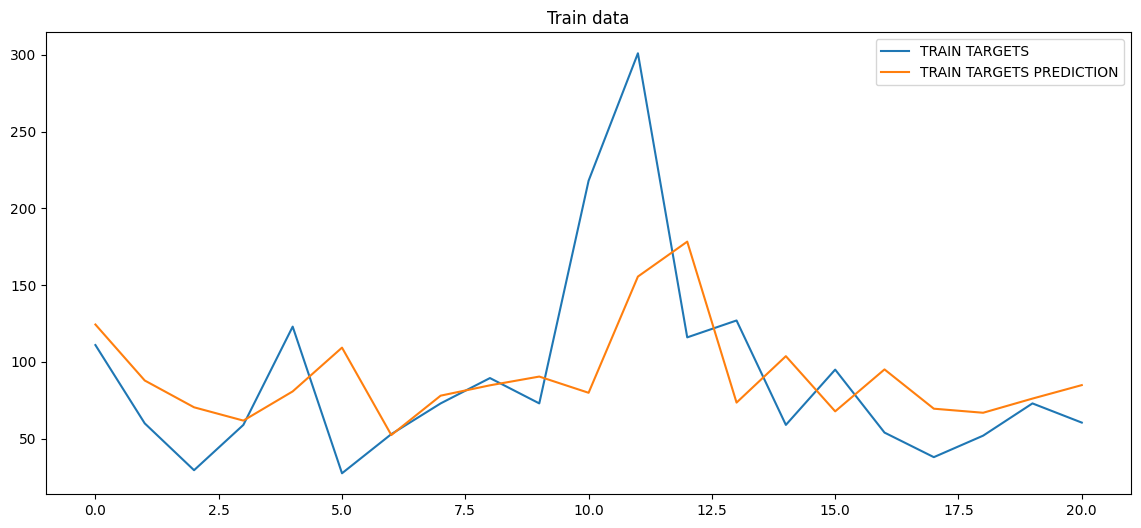

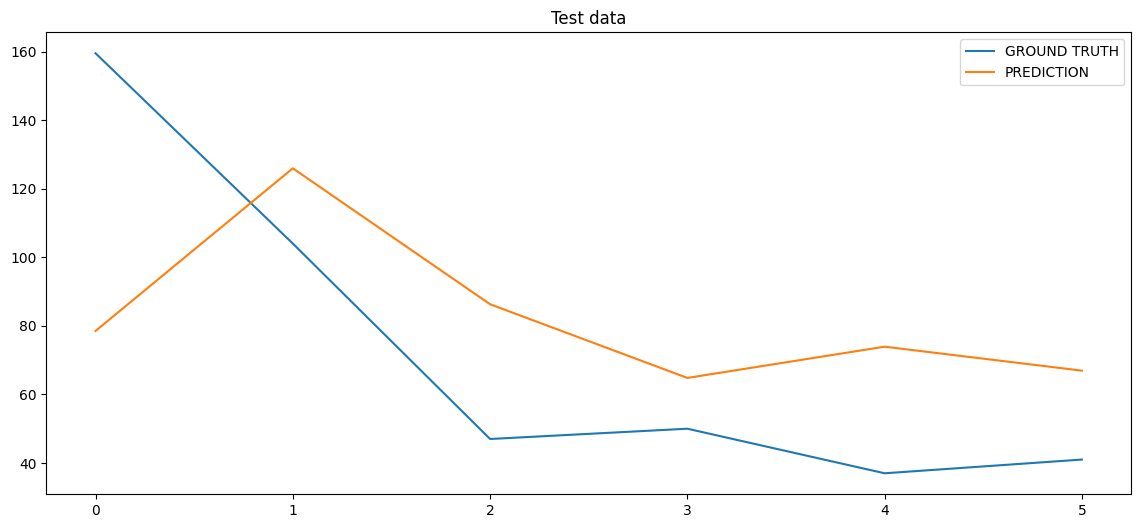

In [46]:
## Linear regression model
model = LinearRegression()
model.fit(X=predictors, y=targets)
# save the model to disk
filename = 'model_LR_v-1.pkl'
pickle.dump(model, open(filename, 'wb'))

# using model on the same training data for completeness
train_pred = model.predict(predictors)
# Plot prediction with test data
test_pred = model.predict(predictors_test)
# Plot prediction with train data
plt.figure(figsize=(14,6))
plt.title('Train data')
plt.plot(range(len(targets)), targets, label='TRAIN TARGETS')
plt.plot(range(len(train_pred)), train_pred, label='TRAIN TARGETS PREDICTION')
plt.legend()
# Plot prediction with test data
test_pred = model.predict(predictors_test)
plt.figure(figsize=(14,6))
plt.title('Test data')
plt.plot(range(len(targets_test)), targets_test, label='GROUND TRUTH')
plt.plot(range(len(test_pred)), test_pred, label='PREDICTION')
plt.legend()

# R squared score for test data
print("train r2 squared error is ", rsquared(targets, train_pred)) #rsquared(targets, train_pred))
print("test r2 squared error is ", rsquared(targets_test, test_pred))#rsquared(targets_test, test_pred))

## Random Forest regressor

train r2 squared error is  874.8613800595238
test r2 squared error is  706.3487494791667


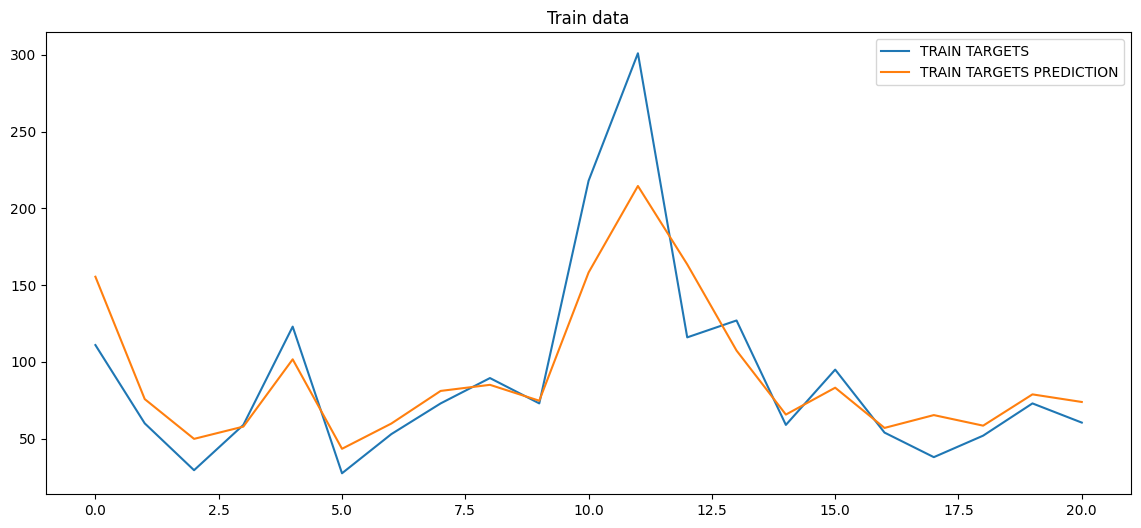

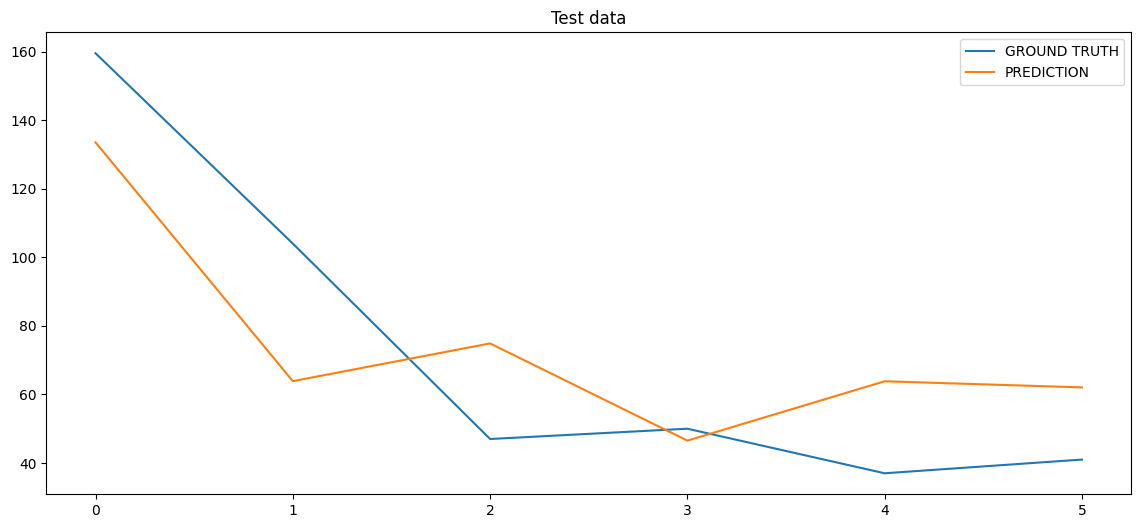

In [47]:
from functions import *
n_estimators_rf=400
model = RandomForestRegressor(n_estimators=n_estimators_rf)
model.fit(X=predictors, y=targets)
# save the model to disk
filename = 'model_LR_v-1.pkl'
pickle.dump(model, open(filename, 'wb'))

# using model on the same training data
train_pred = model.predict(predictors)
# Plot prediction with test data
test_pred = model.predict(predictors_test)
# R squared score for test data



# Plot prediction with train data
plt.figure(figsize=(14,6))
plt.title('Train data')
plt.plot(range(len(targets)), targets, label='TRAIN TARGETS')
plt.plot(range(len(train_pred)), train_pred, label='TRAIN TARGETS PREDICTION')
plt.legend()

# Plot prediction with test data
test_pred = model.predict(predictors_test)
plt.figure(figsize=(14,6))
plt.title('Test data')
plt.plot(range(len(targets_test)), targets_test, label='GROUND TRUTH')
plt.plot(range(len(test_pred)), test_pred, label='PREDICTION')

plt.legend()

# R squared score for test data
print("train r2 squared error is ", rsquared(targets, train_pred))
print("test r2 squared error is ", rsquared(targets_test, test_pred))

## xgboost model

train r2 squared error is  2066.310490385948
test r2 squared error is  2856.0937870309303


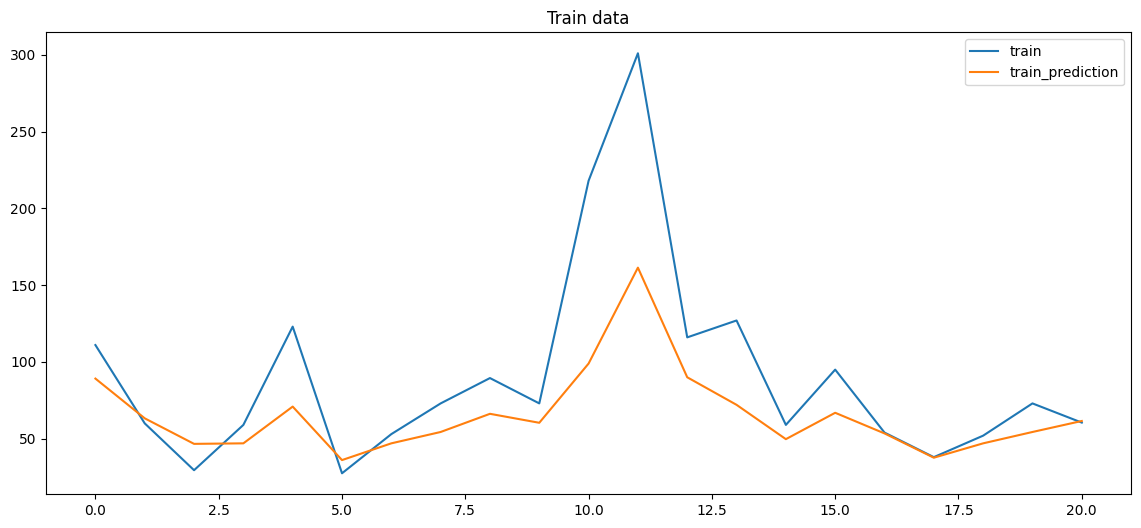

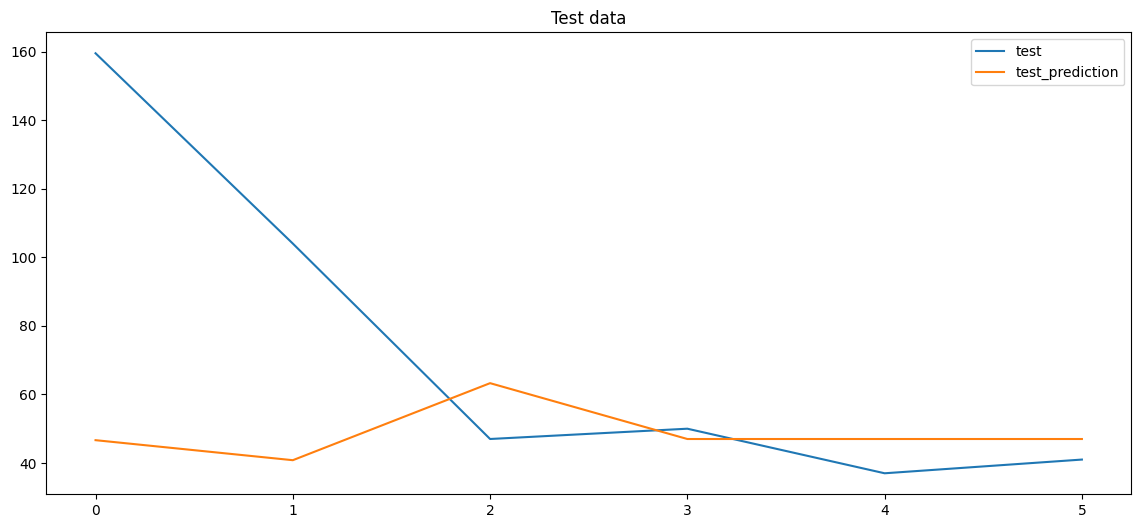

In [48]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(predictors, targets, enable_categorical=False)
dtest_reg = xgb.DMatrix(predictors_test, targets_test, enable_categorical=False)
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 5

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

train_pred = model.predict((dtrain_reg))
test_pred = model.predict(dtest_reg)

# Plot prediction with train data
plt.figure(figsize=(14,6))
plt.title('Train data')
plt.plot(range(len(targets)), targets, label='train')
plt.plot(range(len(train_pred)), train_pred, label='train_prediction')
plt.legend()
print("train r2 squared error is ", rsquared(targets, train_pred))

# Plot prediction with test data
plt.figure(figsize=(14,6))
plt.title('Test data')
plt.plot(range(len(targets_test)), targets_test, label='test')
plt.plot(range(len(test_pred)), test_pred, label='test_prediction')

plt.legend()

# R squared score for test data
print("test r2 squared error is ", rsquared(targets_test, test_pred))